In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from eppy.modeleditor import IDF
import seaborn as sns

In [2]:
def parse_energyplus_datetime_string(st, year=2021):
    st=st.strip()
    month=int(st[0:2])
    day=int(st[3:5])
    hour=int(st[7:9])
    minute=int(st[10:12])
    second=(st[13:15])
    if not hour==24:
        dt=pd.Timestamp(year,month,day,hour,minute)
    else:
        hour=0
        dt=pd.Timestamp(year,month,day,hour,minute)
        dt+=pd.Timedelta('1 day')
    return dt

In [33]:
# Specify path to the IDF file
idf_file_path = r".\input_data\dsb_input_file.idf"

# Specify path to the IDD file
idd_file_path = r".\input_data\Energy+.idd" #  Energy+ v9.4 IDD

# Specify path to the weather file
weather_file_path = r".\input_data\-_FRIBOURG_MN7.epw"

IDF.setiddname(idd_file_path)

# Create an IDF object and load the IDF file
idf = IDF(idf_file_path, weather_file_path)


In [35]:
idf.run(readvars=True,output_directory=r'.\output_data', annual=True)


C:/EnergyPlusV9-4-0\energyplus.exe --weather C:\Users\jamil\Documents\GitHub\REHO\EnergyPlus\input_data\-_FRIBOURG_MN7.epw --output-directory C:\Users\jamil\Documents\GitHub\REHO\EnergyPlus\output_data --annual --idd C:\Users\jamil\Documents\GitHub\REHO\EnergyPlus\input_data\Energy+.idd --readvars C:\Users\jamil\Documents\GitHub\REHO\EnergyPlus\input_data\dsb_input_file_1ec2ec.idf



In [10]:
zone_name = "Zone1"

# Get the Zone object
zone = idf.getobject('ZONE', zone_name)

In [11]:
heating_schedule = idf.getobject("Schedule:Compact", "Block1:Zone1 Heating Setpoint Schedule")

In [12]:
heating_schedule


Schedule:Compact,
    Block1:Zone1 Heating Setpoint Schedule,    !- Name
    Any Number,               !- Schedule Type Limits Name
    Through: 3/31,            !- Field 1
    For: Weekdays SummerDesignDays,    !- Field 2
    Until: 24:00,             !- Field 3
    22,                       !- Field 4
    For: WinterDesignDays,    !- Field 5
    Until: 24:00,             !- Field 6
    22,                       !- Field 7
    For: AllOtherDays,        !- Field 8
    Until: 24:00,             !- Field 9
    22,                       !- Field 10
    Through: 9/30,            !- Field 11
    For: Weekdays Weekends SummerDesignDays,    !- Field 12
    Until: 24:00,             !- Field 13
    0,                        !- Field 14
    For: WinterDesignDays,    !- Field 15
    Until: 24:00,             !- Field 16
    22,                       !- Field 17
    For: AllOtherDays,        !- Field 18
    Until: 24:00,             !- Field 19
    0,                        !- Field 20
    Throu

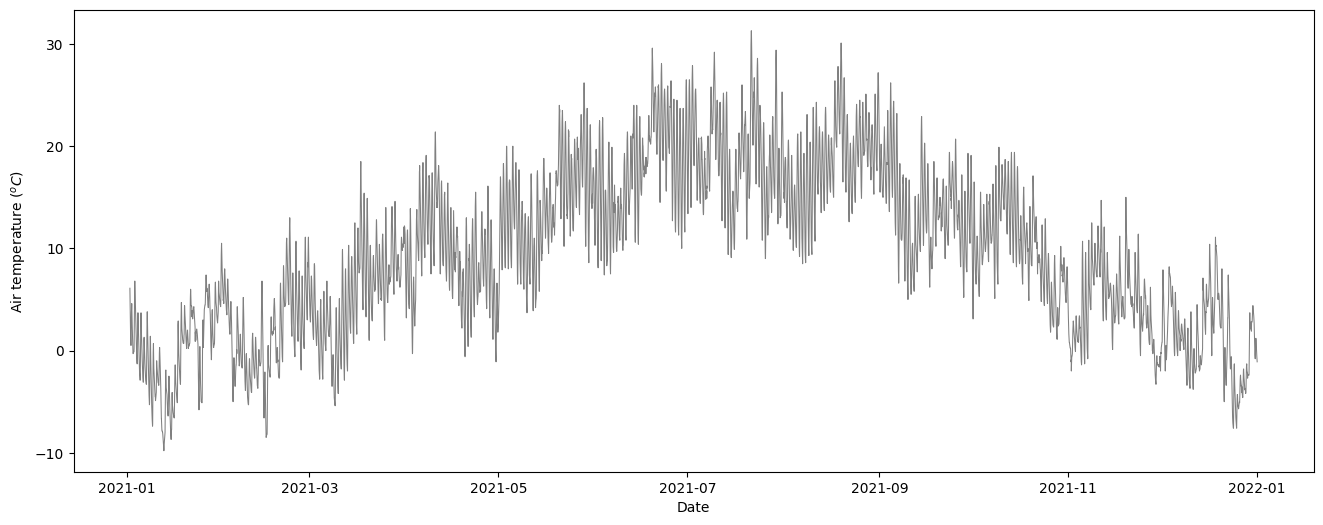

In [13]:
df=pd.read_csv(r".\output_data\eplusout.csv", 
               parse_dates=[0],
               index_col=[0],
               date_parser=parse_energyplus_datetime_string 
              )
fig, ax = plt.subplots(figsize=(16,6))
ax.plot(df['Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)'][48:],  
        color='grey',
        linewidth=0.75
       )
ax.set_xlabel('Date')
ax.set_ylabel('Air temperature (${^o}C$)')  
plt.show()

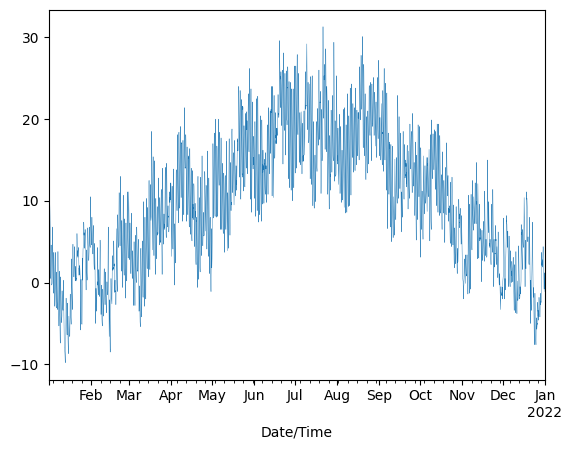

In [14]:
df['Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)'].plot(linewidth=0.3)
plt.show()

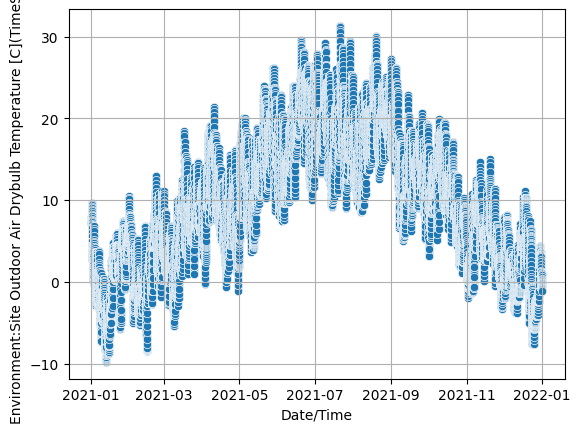

In [27]:
sns.scatterplot(data=df, x='Date/Time',y='Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)')
plt.grid()